## 1. Описание проекта

**Цель проекта:**
Разработать модель нейронной сети, способную предсказывать абсолютную температуру поверхности звезды (в Кельвинах) на основе её физических характеристик.

**Исходные данные:**
Набор содержит сведения о 240 звёздах с признаками:

- L/Lo — относительная светимость

- R/Ro — относительный радиус

- Mv — абсолютная звёздная величина

- Цвет звезды (категориальный признак)

- Тип звезды (от 0 до 5)

- T(K) — целевая переменная: температура в Кельвинах

**Этапы работы:**

1. Загрузка и предварительный анализ данных

2. Визуальный и статистический исследовательский анализ

3. Подготовка данных: кодирование категорий, масштабирование, разбиение на обучающую и тестовую выборки

4. Построение базовой нейросети (baseline) и визуализация прогноза

5. Улучшение модели с перебором гиперпараметров (batch_size, dropout, lr и др.)

6. Сравнение моделей по метрике RMSE (целевое значение: не выше 4500)

7. Выводы и рекомендации

**Выводы:**

В этом проекте мы построили нейросетевую модель, которая умеет предсказывать температуру звезды на основе её физических характеристик — таких как цвет, светимость, радиус, тип и абсолютная звёздная величина. Задача оказалась нетривиальной: данные были «грязными», со скошенными распределениями, выбросами и категориальными признаками, которые требовали отдельного внимания.

Мы тщательно почистили и подготовили данные: применили логарифмирование, масштабирование и OneHot-кодирование, чтобы модель могла работать с ними адекватно. Особое внимание уделили star_color и star_type — оказалось, что эти признаки дают модели много полезной информации.

После базового варианта нейросети мы провели перебор гиперпараметров: тестировали разные активации (ReLU, ELU, LeakyRelu), глубину, ширину, dropout, скорость обучения и batch size. В результате собрали архитектуру, которая стабильно хорошо работает и не переобучается.

Финальная модель даёт RMSE меньше изначально заданного порога 4500 К.

## 2. Загрузка данных

In [1]:
!pip install phik -q

### 2.1. Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import torch
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    PowerTransformer
)
from sklearn.metrics import mean_squared_error

import torch.nn as nn

from math import ceil

from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, loguniform

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### 2.2. Загрузка данных

In [3]:
df = pd.read_csv('/datasets/6_class.csv')
df

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...,...
235,235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,237,8829,537493.000000,1423.0000,-10.73,5,White
238,238,9235,404940.000000,1112.0000,-11.23,5,White


In [4]:
df.to_csv("dataset.csv", index=False)

In [5]:
def df_summary(name: str, df: pd.DataFrame) -> None:
    """
    Функция df_summary принимает на вход str DataFrame и выводит три сводные таблицы с общей информацией:
    
    1. Первая таблица содержит:
       - Первые пять строк датафрейма
    
    2. Вторая таблица содержит:
       - Общее количество строк
       - Общее количество столбцов
       - Количество полных дубликатов строк
    
    я. Третяя таблица содержит информацию о каждом признаке:
       - Название признака
       - Количество пропусков для каждого признака
       - Количество уникальных значений для каждого признака
       - Тип данных каждого признака

    Параметры:
    name (str): Входная строка - название датафрейма;
    df (pd.DataFrame): Входной датафрейм, для которого нужно сформировать сводные таблицы.

    Возвращаемое значение:
    None. Функция выводит таблицы напрямую.
    """ 
    
    # Таблица 1: общее число строк, столбцов и дубликатов
    total_rows = df.shape[0]
    total_columns = df.shape[1]
    total_duplicates = df.duplicated().sum()
    
    summary_1 = pd.DataFrame({
        'Число строк': [total_rows],
        'Число признаков': [total_columns],
        'Число полных дубликатов': [total_duplicates]
    })
    summary_1_t = summary_1.T
    summary_1_t.columns = ['Значение']

    # Таблица 2: информация о каждом признаке
    summary_2 = pd.DataFrame({
        'Признак': df.columns,
        'Число пропусков': df.isnull().sum(),
        'Число уникальных': df.nunique(),
        'Тип': df.dtypes
    }).reset_index(drop=True)
    

    # Вывод таблиц
    print(f'Таблица: {name}', sep='\n')
    
    print('', 'Обзор данных', sep='\n')
    display(df)
    
    print('', 'Статистика признаков', sep='\n')
    display(df.describe())
    
    print('', 'Общая информация', sep='\n')
    display(summary_1_t)
    
    print('', 'Информация о признаках',sep='\n')
    display(summary_2)
    
    print('', '', sep='\n')
    
    # Вывод уникальных значений признаков
    print('Уникальные значения признаков')
    for col in df.columns:
        print('', col, df[col].sort_values().unique(), sep='\n')
    

In [6]:
df_summary('overall_data', df)

Таблица: overall_data

Обзор данных


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...,...
235,235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,237,8829,537493.000000,1423.0000,-10.73,5,White
238,238,9235,404940.000000,1112.0000,-11.23,5,White



Статистика признаков


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000



Общая информация


,Значение
Число строк,240
Число признаков,7
Число полных дубликатов,0



Информация о признаках


,Признак,Число пропусков,Число уникальных,Тип
0,Unnamed: 0,0,240,int64
1,Temperature (K),0,228,int64
2,Luminosity(L/Lo),0,208,float64
3,Radius(R/Ro),0,216,float64
4,Absolute magnitude(Mv),0,228,float64
5,Star type,0,6,int64
6,Star color,0,19,object




Уникальные значения признаков

Unnamed: 0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 23

### Выводы

1. данные загружены корректно и соответствуют описанию
2. в данных 240 записей и 7 признаков (6 количественных и 1 категориальный)
3. признак 'Unnamed: 0' дублирует информацию в индексе таблицы (исключим из дальнейшег оанализа)
4. приведем названия признаков к единому формату (snake_case)
5. в значениях признака Star color обнаружены неявные дубликаты (устраним на этапе предобработки данных)

In [7]:
df2 = df.drop('Unnamed: 0', axis=1)
df2.head(2)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red


## 3. Предобработка и анализ данных

## 3.1. Предобработка данных

### 3.1.1.  Форматирование названия признаков

In [8]:
# форматирование
df2.columns = (
    df2.columns
    .str.replace(r'\s*\(', ' (', regex=True)  # пробел перед скобкой
    .str.strip()                              # убрать пробелы по краям
    .str.lower()                              # нижний регистр
    .str.replace(r'\s+', '_', regex=True)     # пробелы → "_"
)

df2.head(1)

,temperature_(k),luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),star_type,star_color
0,3068,0.0024,0.17,16.12,0,Red


### 3.1.2. Форматирование значений признака star_color

In [9]:
# форматирование
df2['star_color'] = (
    df2['star_color']
    .str.strip()
    .str.lower()
)

df2['star_color'].sort_values().unique()

array(['blue', 'blue white', 'blue-white', 'orange', 'orange-red',
       'pale yellow orange', 'red', 'white', 'white-yellow', 'whitish',
       'yellow-white', 'yellowish', 'yellowish white'], dtype=object)

In [10]:
# устранение неявных дубликатов
df2['star_color'].replace({
    'blue white': 'blue-white',
    'white yellow': 'yellow-white',
    'yellow white': 'yellow-white',
    'yellowish white': 'yellow-white',
    'white-yellow': 'yellow-white',
    'yellowish': 'yellow',
    'whitish': 'white',
    'orange-red': 'orange',
    'pale yellow orange': 'yellow'
}, inplace=True)

df2['star_color'].value_counts()

red             112
blue             56
blue-white       41
yellow-white     12
white            12
yellow            4
orange            3
Name: star_color, dtype: int64

## 3.2. Анализ данных

In [11]:
def visualise_all(df):
    # Выделяем числовые и категориальные колонки
    num_cols = df.select_dtypes(include='number').columns
    cat_cols = df.select_dtypes(include='category').columns

    # Статистика
    display(df.describe())

    # Визуализация числовых колонок (гистограммы)
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=50)
        plt.title(f'Распределение: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.tight_layout()
        plt.show()

    # Scatter matrix (pairplot) для числовых колонок
    if len(num_cols) >= 2:
        sns.pairplot(df, diag_kind="kde", corner=True)
        plt.suptitle('Scatter Matrix (Pairplot)', y=1.02)
        plt.show()

    # Визуализация категориальных колонок
    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index[:10])
        plt.title(f'Распределение категорий: {col}')
        plt.xlabel(col)
        plt.ylabel('Кол-во записей')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

,temperature_(k),luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),star_type,star_color
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000,2.179167
std,9552.425037,179432.244940,517.155763,10.532512,1.711394,1.643162
min,1939.000000,0.000080,0.008400,-11.920000,0.000000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000,3.000000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000,3.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000,6.000000


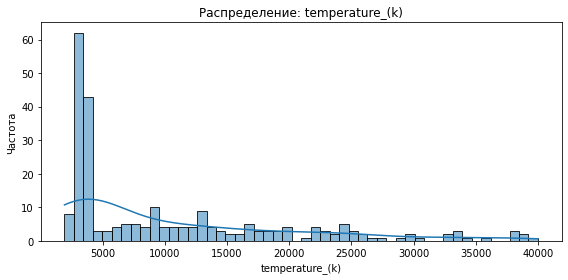

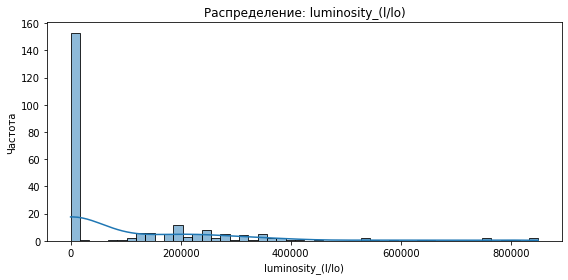

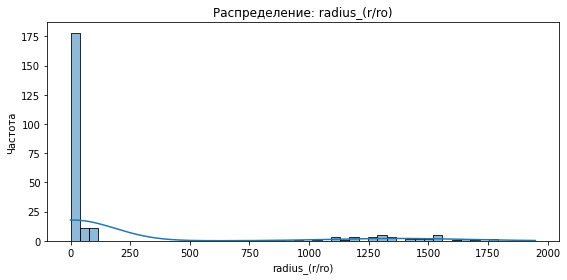

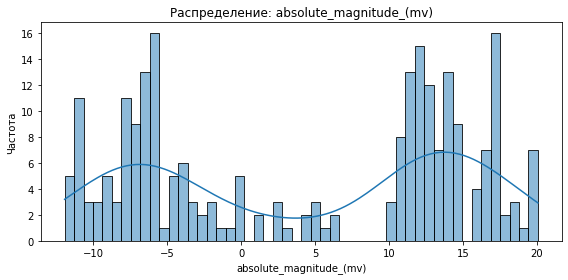

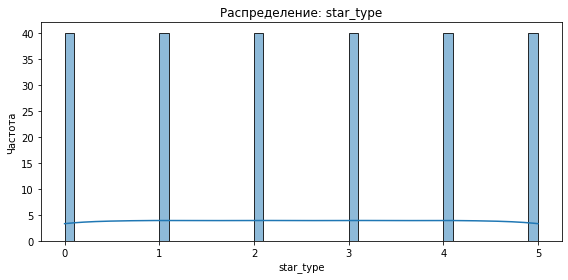

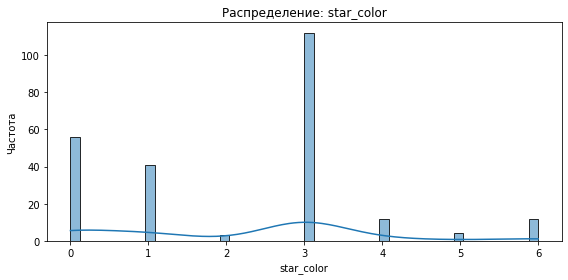

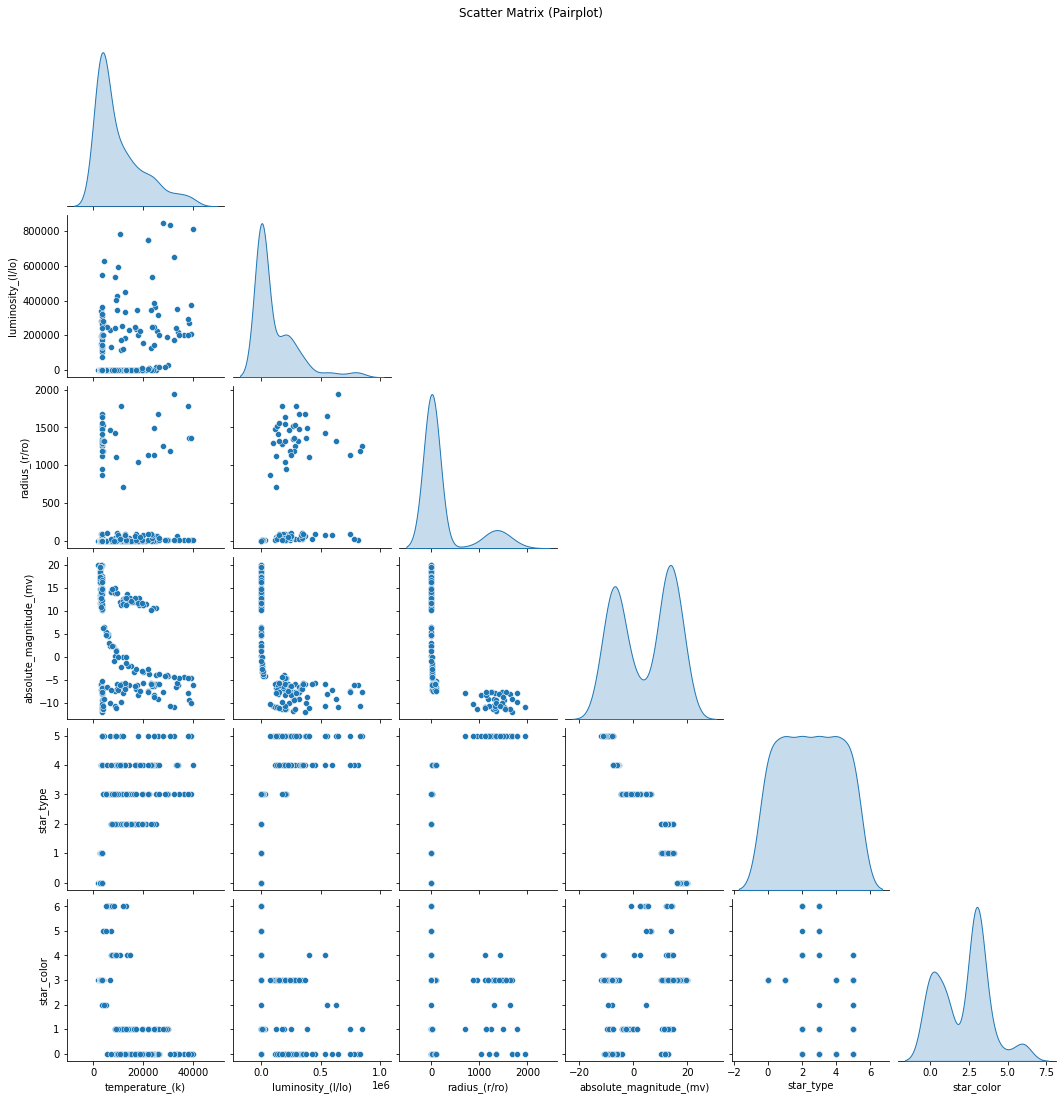

In [12]:
dfv = df2.copy()
dfv['star_color'] = dfv['star_color'].astype('category').cat.codes
visualise_all(dfv)

**Анализ признаков:**

1. temperature_(k) - широкий диапазон значений (от 1939 до 40000), как следствие скошенное распределение. На начальном этапе, ограничимся масштабированием (без нормализации распределения);
2. luminosity_(l/lo) - очень широкий диапазон значений (от 0.000080	до 849420), выбросы, большое стандартное отклонение как следствие скошенное распределение. К масштабированию добавим нормализацию распределения;
3. radius_(r/ro) - широкий диапазон значений (от 0.0084 до 1948.5), логнормальное распределние. Нормализуем распределение с последующим масштабированием;
4. absolute_magnitude_(mv) - диапазон разумный. Ограничимся масштабированием;
5. star_type - категориальный признак. Закодируем методом OneHotEncoding;
6. star_color - категориальный признак. Закодируем методом OneHotEncoding.

### 3.3. Корреляционная матрица

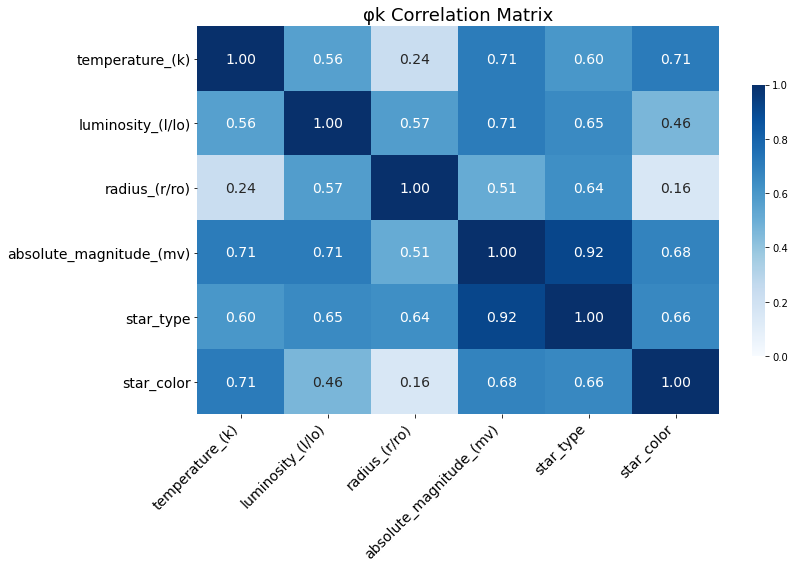

In [13]:
# Расчёт phi_k матрицы
phik_matrix = df2.phik_matrix(
    interval_cols=df2.select_dtypes(include='number')
)

# Динамический размер графика
num_features = len(phik_matrix.columns)
fig_width = max(1.5 * num_features, 12)
fig_height = max(1.2 * num_features, 8)

# Визуализация
plt.figure(figsize=(fig_width, fig_height))
heatmap = sns.heatmap(
    phik_matrix,
    vmin=0, vmax=1,
    cmap='Blues',
    annot=True, fmt=".2f",
    annot_kws={"size": 14},     
    cbar_kws={"shrink": 0.7}
)

# Подписи
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14, rotation=45, ha='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14, rotation=0)

plt.title("φk Correlation Matrix", fontsize=18)
plt.tight_layout()
plt.show()


Корреляция с целевой переменной (temperature_(k)):
- star_color - очень высокая (0.83);
- absolute_magnitude_(mv) - высокая (0.71);
- star_type - умеренная (0.6);
- luminosity_(l/lo) - умеренная (0.56);
- radius_(r/ro) - слабая (0.24)

Между признаками наблюдается сильная корреляция (star_type и absolute_magnitude_(mv) 0.92 и т.д.), однако в отличии от линейных моделей, для нейронных сетей это не так критично так как они устойчивы к мультиколлинеарности. Для обучения используем все признакми.

In [14]:
df3 = df2.copy()

### 3.3. Выводы

**На этапе предобработки данных** отформатирвоаны названия признаков (snake_case) . Оотфроматированы значения признака star_color.

**На этапе анализа данных** проведены статистический, графический и корреляционный анализы. Статичстический и графический анализы выявмлм необходимость, в нормализации распределений признаков обладающих скошенностью распределения и выбросами. Корреляционный анализ помог выявить наиболее полезные признаки: star_color, absolute_magnitude, star_type с корреляцией 0.83, 0.71 и 0.6 соответственно.

## 4. Построение базовой нейронной сети

**План обучения**

Для начала нормализуем признаки luminosity_(l/lo), radius_(r/ro) и absolute_magnitude_(mv) методом PowerTransformer, после чего разделим данные на тренировочную и тестовую выборки и затем масштабируем количественные и закодируем категориальные признаки методами StandardScaler и OneHotEncoder соответсвтенно.


Определим лучшую базовую модель перебрав различные архитектуры сетей отличающиеся друг от друга количеством слоев и нейронов в них и функцией активациии.


### 4.1. Нормализация признаков

In [15]:
f_cols = df3[[
    'luminosity_(l/lo)',
    'radius_(r/ro)',
    'absolute_magnitude_(mv)'
]]

ptf = PowerTransformer(method='yeo-johnson', standardize=False)

for col in f_cols:
    df3[col] = ptf.fit_transform(df3[[col]])
    
df3

,temperature_(k),luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),star_type,star_color
0,3068,0.002397,0.153220,14.272632,0,red
1,3042,0.000500,0.140246,14.676167,0,red
2,2600,0.000300,0.095670,16.434011,0,red
3,2800,0.000200,0.145036,14.718163,0,red
4,1939,0.000138,0.096550,17.566276,0,red
...,...,...,...,...,...,...
235,38940,8.040051,2.867303,-10.973383,5,blue
236,30839,8.319027,2.853643,-11.784477,5,blue
237,8829,8.167975,2.872341,-11.900595,5,white
238,9235,8.067784,2.845765,-12.482076,5,white


### 4.2. Разделение на тренирвоочную и тестовую выборки

In [16]:
X = df3.drop('temperature_(k)', axis=1)
y = df3['temperature_(k)']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.15,
    shuffle=True,
    stratify=df3['star_color'],
    random_state=seed
)

X_train.shape, X_test.shape

((204, 5), (36, 5))

### 4.3. Масштабирование признаков

In [17]:
# Инициализация
X_scaler = StandardScaler()
ohe = OneHotEncoder(
    drop='first'
    #handle_unknown='ignore'
)



# Преобразование X_train
X_train_num = X_train.drop('star_type', axis=1).select_dtypes(include='number')
X_train_cat = X_train[['star_type', 'star_color']]

X_train_scaled = X_scaler.fit_transform(X_train_num)
X_train_ohe = ohe.fit_transform(X_train_cat)


# Таргет — без масштабирования
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)



# Преобразование X_test
X_test_num = X_test.drop('star_type', axis=1).select_dtypes(include='number')
X_test_cat = X_test[['star_type', 'star_color']]

X_test_scaled = X_scaler.transform(X_test_num)
X_test_ohe = ohe.transform(X_test_cat)

# Таргет — без масштабирования
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)



# Объединение и преобразование в тензоры
X_train_tensor = torch.tensor(
    np.hstack([X_train_scaled, X_train_ohe.toarray()]),
    dtype=torch.float32
)

X_test_tensor = torch.tensor(
    np.hstack([X_test_scaled, X_test_ohe.toarray()]),
    dtype=torch.float32
)


print(
    f'Размер X_train: {X_train_tensor.shape}',
    f'Размер X_test: {X_test_tensor.shape}',
    f'Размер y_train: {y_train_tensor.shape}', 
    f'Размер y_test {y_test_tensor.shape}',
    sep='\n'
)

Размер X_train: torch.Size([204, 14])
Размер X_test: torch.Size([36, 14])
Размер y_train: torch.Size([204, 1])
Размер y_test torch.Size([36, 1])


### 4.4. Архитектура базовой нейронной сети

Расммторим архитектуры со следующими компонентамифи:

1. список слоеев и нейронов 
    - 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1
    - 14, 11, 9, 6, 3, 1
2. сисок функций активации
    - ReLU
    - LeakyRelU
    - ELU
3. инициализация весов kaiming

**вводные данные**

In [18]:
layers = [
    [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    [14, 11, 9, 6, 3, 1]
]

afs = [
    nn.ReLU(),
    nn.LeakyReLU(),
    nn.ELU()
]

def init_weights_kaiming_relu(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

def init_weights_kaiming_leaky_relu(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='leaky_relu')
        
num_epochs = 3000
lr = 0.01
batch_size = 60
num_batches = ceil(len(X_train_tensor)/batch_size)
loss_fn = nn.MSELoss()

results = {}
predictions = {}

**конструктор архитектур**

In [19]:
def build_model(layer_sizes, activation_fn, batch=False):
    net = []

    if not batch:
        for l in range(1, len(layer_sizes)-1):
            net.append(nn.Linear(layer_sizes[l-1], layer_sizes[l]))
            #net.append(nn.Dropout())
            net.append(activation_fn)

        net.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))

    else:
        for l in range(1, len(layer_sizes)-1):
            net.append(nn.Linear(layer_sizes[l-1], layer_sizes[l]))
            net.append(nn.BatchNorm1d(layer_sizes[l]))
            net.append(activation_fn)

        net.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))

    # выбор инициализации
    if isinstance(activation_fn, nn.LeakyReLU):
        return nn.Sequential(*net).apply(init_weights_kaiming_leaky_relu)
    else:
        return nn.Sequential(*net).apply(init_weights_kaiming_relu)

In [20]:
nets = {}              # архитектуры без батчей
nets_batched = {}      # архитектуры с батчами
num = 1

for layer in layers:
    for af in afs:
        nets[f'net_{num}'] = build_model(layer, af, False)
        num += 1
        
nets, nets_batched

({'net_1': Sequential(
    (0): Linear(in_features=14, out_features=13, bias=True)
    (1): ReLU()
    (2): Linear(in_features=13, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=11, bias=True)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=9, bias=True)
    (9): ReLU()
    (10): Linear(in_features=9, out_features=8, bias=True)
    (11): ReLU()
    (12): Linear(in_features=8, out_features=7, bias=True)
    (13): ReLU()
    (14): Linear(in_features=7, out_features=6, bias=True)
    (15): ReLU()
    (16): Linear(in_features=6, out_features=5, bias=True)
    (17): ReLU()
    (18): Linear(in_features=5, out_features=4, bias=True)
    (19): ReLU()
    (20): Linear(in_features=4, out_features=3, bias=True)
    (21): ReLU()
    (22): Linear(in_features=3, out_features=2, bias=True)
    (23): ReLU()
    (24): Linear(in_features=2, out_features=1, bias=True)
  ),
  

### 4.5. Обучение базовой нейронной сети

**обучение НС без разделения на батчи**

In [21]:
def train_full_batch_with_early_stopping(nets, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                     loss_fn, lr=0.001, num_epochs=1000, patience=500):

    for name, net in nets.items():
        print(f"\n{name}_no_batches")
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)

        best_loss = float('inf')
        no_improve = 0

        start_time = time.time()

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            loss = loss_fn(net(X_train_tensor), y_train_tensor)
            loss.backward()
            optimizer.step()

            net.eval()
            val_loss = loss_fn(net(X_test_tensor), y_test_tensor)

            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                no_improve = 0
            else:
                no_improve += 1

            if epoch % (num_epochs*0.1) == 0:
                print(f"Epoch {epoch}: val RMSE = {np.sqrt(val_loss.item()):.2f}")

            if no_improve >= patience:
                print(f"Early stopped at epoch {epoch}")
                break

        duration = time.time() - start_time
        final_preds = net(X_test_tensor)
        final_rmse = np.sqrt(loss_fn(final_preds, y_test_tensor).item())

        results[f'{name}_no_batches'] = {
            'rmse': round(final_rmse, 2),
            'time_sec': round(duration, 2)
        }
        predictions[f'{name}_no_batches'] = final_preds


In [22]:
train_full_batch_with_early_stopping(
    nets, 
    X_train_tensor,
    y_train_tensor, 
    X_test_tensor, 
    y_test_tensor, 
    loss_fn, 
    lr=lr, 
    num_epochs=num_epochs,
    patience=500
)


net_1_no_batches
Epoch 0: val RMSE = 13016.47
Epoch 300: val RMSE = 3717.53
Epoch 600: val RMSE = 3463.87
Epoch 900: val RMSE = 3610.02
Early stopped at epoch 1066

net_2_no_batches
Epoch 0: val RMSE = 13016.65
Epoch 300: val RMSE = 3858.08
Epoch 600: val RMSE = 3533.29
Epoch 900: val RMSE = 3440.52
Epoch 1200: val RMSE = 3458.84
Epoch 1500: val RMSE = 3477.26
Early stopped at epoch 1533

net_3_no_batches
Epoch 0: val RMSE = 13009.92
Epoch 300: val RMSE = 3769.36
Epoch 600: val RMSE = 3486.23
Epoch 900: val RMSE = 3476.68
Epoch 1200: val RMSE = 5792.98
Early stopped at epoch 1298

net_4_no_batches
Epoch 0: val RMSE = 13017.14
Epoch 300: val RMSE = 13014.73
Epoch 600: val RMSE = 13012.57
Epoch 900: val RMSE = 13010.40
Epoch 1200: val RMSE = 13008.24
Epoch 1500: val RMSE = 13006.07
Epoch 1800: val RMSE = 13003.91
Epoch 2100: val RMSE = 13001.75
Epoch 2400: val RMSE = 12999.58
Epoch 2700: val RMSE = 12997.42

net_5_no_batches
Epoch 0: val RMSE = 13016.94
Epoch 300: val RMSE = 6673.33
Epo

**обучение НС с разделением на батчи**

In [23]:
pd.DataFrame(results).T.sort_values(by='rmse')

,rmse,time_sec
net_5_no_batches,3458.84,15.51
net_2_no_batches,3466.42,16.41
net_6_no_batches,3496.11,17.89
net_1_no_batches,3735.22,10.75
net_3_no_batches,6619.44,12.70
net_4_no_batches,12995.27,19.39


In [24]:
best_architecture = 'net_2_no_batches'

Первые 3 архитектуры очень близки по качеству и времени обучения (RMSE 3458, 3466, 3496 и 14.90, 14.18, 17.81 секунд соответственно). За базову модель примем модель net_2_no_batches, т.к. по качеству она практически не уступает первой но быстрее в обучении.

### 4.6. Графическое представление результатов лучшей архитектуры

Построим график фактических и прогнозных значений температуры звезд базовой модели (RMSE 3466, время обучения 14.18 сек) 

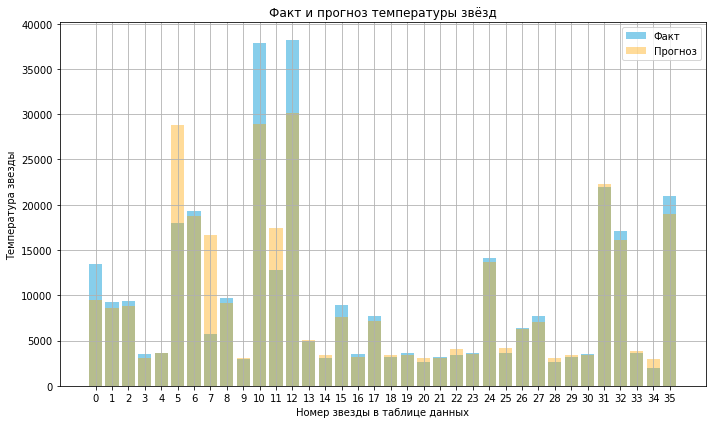

In [25]:
data_for_plot = pd.DataFrame({
    'y_true': y_test, 
    'y_preds': np.round(predictions[best_architecture].detach().numpy().flatten())
})
data_for_plot


x = np.arange(len(data_for_plot)) 

# сравнительная диаграмма
plt.figure(figsize=(10, 6))
plt.bar(x, data_for_plot['y_true'], label='Факт', color='skyblue')
plt.bar(x, data_for_plot['y_preds'], label='Прогноз', color='orange', alpha=.4)

plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
plt.title('Факт и прогноз температуры звёзд')
plt.legend()
plt.grid(True)
plt.xticks(ticks=x)

plt.tight_layout()
plt.show()

### 4.7. Выводы

Для поиска базовой модели были пройдены следующие этапы: нормализованы и масштабированы данные с последующим разделением на тестовую и тренировочную выборки, определены  и обучены архитектуры нейронных сеетй.

Нормализация методом PowerTransform коснулась признаков с широкими диапазонами значений и соддержащих в себе выбросы - 'luminosity_(l/lo)', 'radius_(r/ro)', 'absolute_magnitude_(mv)'. Масштабированию методом StandardScaler подверглись все признаки датасета кроме целевого. Разделение данных методом train_test_split.

Рассмотрены различные архитектуры отличающиеся следующими компонентами:
1. список слоеев и нейронов 
    - 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1
    - 14, 11, 9, 6, 3, 1
2. сисок функций активации
    - ReLU
    - LeakyRelU
    - ELU
3. инициализация весов kaiming

Метрика качества определена заданием - RMSE. Функция потерь MSE.

Лучшая модель net_2_no_batches со значением RMSE 3466 и временем обучения 14.18 секунд принята за базовую.

## 5. Улучшение нейронной сети

Улучшить качество базовой нейронной сети попробуем несколькими инструментами: добавим регуляризацию (dropuot/ Batch Normalization) и перебирем гиперпараметры (шаг обучения (learning_rate), параметр метода регуляризации (dropout), размер батча (batch_size)) методом по принципу схожему с RandomizedSearch библиотеки sklearn, сгенерировав случайным образом сетку гиперпараметров.

### 5.1. Модели в классе nn.Module

In [26]:
# модель без разделения на батчи
# аржитектура net_2_no_batches
class NetDropout(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.model = nn.Sequential(
             nn.Linear(in_features=14, out_features=13, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
            
             nn.Linear(in_features=13, out_features=12, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
    
             nn.Linear(in_features=12, out_features=11, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
             
             nn.Linear(in_features=11, out_features=10, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
    
             nn.Linear(in_features=10, out_features=9, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
    
             nn.Linear(in_features=9, out_features=8, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
    
             nn.Linear(in_features=8, out_features=7, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
    
             nn.Linear(in_features=7, out_features=6, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
             
             nn.Linear(in_features=6, out_features=5, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
             
             nn.Linear(in_features=5, out_features=4, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
    
             nn.Linear(in_features=4, out_features=3, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
    
             nn.Linear(in_features=3, out_features=2, bias=True),
             nn.Dropout(p=dropout, inplace=False),
             nn.LeakyReLU(negative_slope=0.01),
             
             nn.Linear(in_features=2, out_features=1, bias=True)
        )

    def forward(self, x):
        return self.model(x)    



# модель с разделенеим на батчи
class NetBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=14, out_features=13, bias=True),
            nn.BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=13, out_features=12, bias=True),
            nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=12, out_features=11, bias=True),
            nn.BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=11, out_features=10, bias=True),
            nn.BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=10, out_features=9, bias=True),
            nn.BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=9, out_features=8, bias=True),
            nn.BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=8, out_features=7, bias=True),
            nn.BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=7, out_features=6, bias=True),
            nn.BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=6, out_features=5, bias=True),
            nn.BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=5, out_features=4, bias=True),
            nn.BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=4, out_features=3, bias=True),
            nn.BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=3, out_features=2, bias=True),
            nn.BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.Linear(in_features=2, out_features=1, bias=True) 
        )

    def forward(self, x):
        return self.model(x)

### 5.2. Функции обучения нейронных сетей

In [27]:
def train_no_batching(model_class, config, patience=500):
    model = model_class(config['dropout'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    loss_fn = nn.MSELoss()

    best_loss = float('inf')
    no_improve = 0

    start = time.time()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_tensor)
        loss = loss_fn(preds, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Валидируем
        model.eval()
        val_loss = loss_fn(model(X_test_tensor), y_test_tensor).item()

        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    duration = time.time() - start

    model.eval()
    preds = model(X_test_tensor).detach().numpy()
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return model, rmse, duration, preds

In [28]:
def train_with_batches(model_class, config, patience=500):
    model = model_class()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    loss_fn = nn.MSELoss()
    batch_size = config['batch_size']
    num_batches = len(X_train_tensor) // batch_size

    best_loss = float('inf')
    no_improve = 0

    start = time.time()
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train_tensor))
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            indexes = order[start_idx:start_idx + batch_size]
            X_batch = X_train_tensor[indexes]
            y_batch = y_train_tensor[indexes]

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = loss_fn(model(X_test_tensor), y_test_tensor).item()

        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            break

    duration = time.time() - start

    model.eval()
    preds = model(X_test_tensor).detach().numpy()
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return model, rmse, duration, preds


### 5.3. Генератор сетки гиперпараметров

In [29]:
param_distributions = {
    'dropout': uniform(0.2, 0.5),               # от 0.2 до 0.7
    'lr': loguniform(1e-4, 1e-2),               # [0.0001, 0.01]
    'batch_size': [32, 64]               
}

samples = list(ParameterSampler(param_distributions, n_iter=10, random_state=seed))

### 5.4. Обучение нейронных сетей

In [30]:
results_2 = {}
predictions_2 = {}

for i, sample in enumerate(samples):
    print(f"\n🔁 Config {i+1}: {sample}")

    model, rmse, duration, preds = train_no_batching(NetDropout, sample)
    results_2[f'dropout_model_{i}'] = {'rmse': round(rmse), 'time': round(duration)}
    predictions_2[f'dropout_model_{i}'] =  {'preds': preds}
    

    model, rmse, duration, preds = train_with_batches(NetBatchNorm, sample)
    results_2[f'batchnorm_model_{i}'] = {'rmse': round(rmse), 'time': round(duration)}
    predictions_2[f'batchnorm_model_{i}'] =  {'preds': preds}


🔁 Config 1: {'batch_size': 32, 'dropout': 0.5982714934301164, 'lr': 0.0002327392228062871}
Early stopping at epoch 1940

🔁 Config 2: {'batch_size': 64, 'dropout': 0.4993292420985183, 'lr': 0.00020513382630874495}

🔁 Config 3: {'batch_size': 32, 'dropout': 0.24998745790900145, 'lr': 0.000828891686688514}

🔁 Config 4: {'batch_size': 32, 'dropout': 0.5005575058716044, 'lr': 0.0026070247583707662}
Early stopping at epoch 632

🔁 Config 5: {'batch_size': 64, 'dropout': 0.22820578951355014, 'lr': 0.0027796975515266813}
Early stopping at epoch 2392

🔁 Config 6: {'batch_size': 64, 'dropout': 0.3061695553391381, 'lr': 0.00023102018878452932}

🔁 Config 7: {'batch_size': 32, 'dropout': 0.5087407548138583, 'lr': 0.0016722697006183672}

🔁 Config 8: {'batch_size': 32, 'dropout': 0.4159725093210579, 'lr': 0.0003823475224675185}
Early stopping at epoch 2378

🔁 Config 9: {'batch_size': 32, 'dropout': 0.39993048585762775, 'lr': 0.0001239742034078414}

🔁 Config 10: {'batch_size': 64, 'dropout': 0.3831809

In [31]:
pd.DataFrame(results_2).T.sort_values(by='rmse')

,rmse,time
batchnorm_model_9,3282,177
batchnorm_model_2,3315,371
batchnorm_model_7,3418,352
batchnorm_model_6,3418,244
batchnorm_model_0,3461,339
batchnorm_model_8,3468,363
batchnorm_model_5,3496,179
batchnorm_model_4,3659,68
batchnorm_model_1,3714,183
batchnorm_model_3,3960,156


### 5.5. Выводы

Тюнинг базовой модели можно считать удачным манекром. Удалось повысить качество модели с 3466 до 3104 однако для получения такого результата необходимо приблизительно в восеь раз больше времени 128 секунды против 15.

Таким образом повысить каечство базовой модели возможно в ущерб времени обучения. Лучшей модель таким образом становится модель с архитектурой вкючающую в себя Batch Normalization со следующими параметрами: 'batch_size': 64, 'lr': 0.0022941144328643983

## 6. Общие выводы

В этом проекте мы построили нейросетевую модель, которая умеет предсказывать температуру звезды на основе её физических характеристик — таких как цвет, светимость, радиус, тип и абсолютная звёздная величина. Задача оказалась нетривиальной: данные были «грязными», со скошенными распределениями, выбросами и категориальными признаками, которые требовали отдельного внимания.

Мы тщательно почистили и подготовили данные: применили логарифмирование, масштабирование и OneHot-кодирование, чтобы модель могла работать с ними адекватно. Особое внимание уделили star_color и star_type — оказалось, что эти признаки дают модели много полезной информации.

После базового варианта нейросети мы провели перебор гиперпараметров: тестировали разные активации (ReLU, ELU, LeakyRelu), глубину, ширину, dropout, скорость обучения и batch size. В результате собрали архитектуру, которая стабильно хорошо работает и не переобучается.

Финальная модель даёт RMSE меньше изначально заданного порога 4500 К.